# Integrating the HFM library into pyKasso #
C. Fandel 2020 <br>
Purpose: replace the skfmm module with the agd-hfm module to improve network generation capability

TO-DO:

*Necessary*
- [X] add cost map
- [X] make cost map reflect realistic values
- [X] add DxV and DyV (x and y components of gradient in each cell of array)
    - [X] option to calculate from DEM
        - [X] rotate DEM csv by 90 degrees
    - [ ] option to import from GSLIB file
- [X] add alpha map (travel cost in same direction as gradient)
- [X] add beta map (travel cost perpendicular to gradient)
- [X] convert cost map into HFM library's input format
- [X] use the HFM library to compute travel time map and paths
- [ ] convert paths to node/link format

*Useful (save for later)*
- [ ] label geology colorbar in show_catchment() so we know which colors correspond to karstifiable units
- [ ] replace all code_ functions with cost_ functions
- [ ] add to get, set, update, and show functions
    - [ ] topography
    - [ ] cost
- [ ] ask if can change grid names to be more informative

### Issues ###
Grid: translation from point to index is offset, and grid is also offset, causing problems with multiple conduit iterations <br>
Conduits are not attractive enough? <br>
Next: convert conduits to a network?

### Setup & imports ###
Need to import a local version of pykasso be able to make and test changes.
Use one of the two methods below (but not both).
Question: Is one way better than the other in some way?

In [2]:
method = 2

#Method 1: using importlib
if method==1:
    import importlib.util
    spec = importlib.util.spec_from_file_location('pykasso', 'C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso/base.py')
    pk = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(pk)

#Method 2: setting the path variable to the path to the local version 
#This version allows reloading the module to see changes
if method==2:
    import sys
    sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
    import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

#Check that it worked:
#catchment = pk.SKS() #create a simple model
#You should see a printed statement indicating that you are using a development version of the package.
#If you do not see this statement, you are using the main version, and changes you make to the local version will have no effect.

In [3]:
#Import the rest of the modules needed:
import os            
import sys           
import importlib
import numpy as np
from matplotlib import pyplot as plt

#all fast-marching-related imports
import agd
from agd import Eikonal
from agd.Metrics import Riemann
from agd.Plotting import quiver
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
norm_infinity = ad.Optimization.norm_infinity

os.chdir('C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso')
os.getcwd()

'C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso'

### Test on built-in Betteraz system ###

CAUTION: You are using the development version of this package.


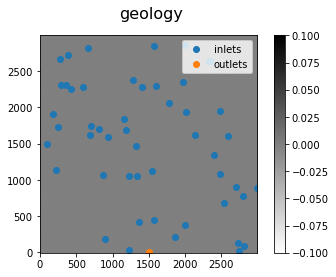

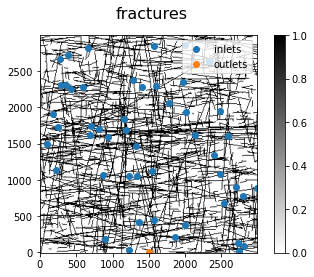


 This network contains  6  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


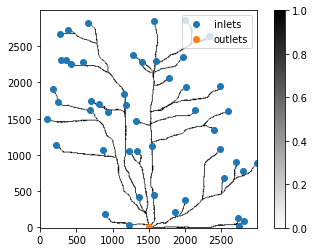

(300, 300)

In [211]:
importlib.reload(pk)

betteraz = pk.SKS('pykasso/default_files/settings.yaml')
betteraz.show_catchment(data='geology')
betteraz.show_catchment(data='fractures')
betteraz.compute_karst_network()
betteraz.show()

betteraz.geology.data['geology']['data'].shape

### Set up a simple one-valley system ###

CAUTION: You are using the development version of this package.


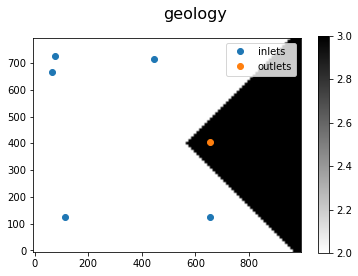

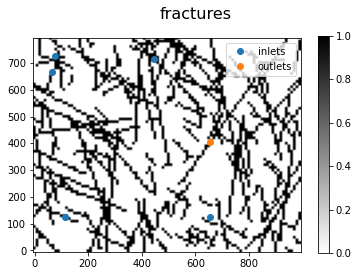

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.011 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.009 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45

 This network contains  3  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


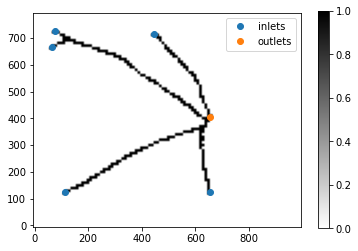

In [279]:
importlib.reload(pk)

catchment = pk.SKS('notebooks/inputs/valley1/settings.yaml', rand_seed=1) #import settings and options from input folder
catchment.show_catchment(data='geology')
catchment.show_catchment(data='fractures')
catchment.compute_karst_network()
catchment.show()

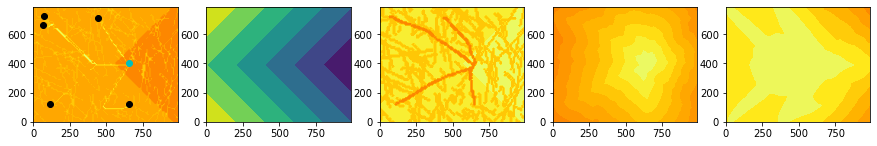

In [280]:
f,ax = plt.subplots(1,5, figsize=(15,5))
ax[0].contourf(catchment.grid.x, catchment.grid.y, catchment.maps['cost'][-1], cmap='Wistia')
ax[0].scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='c')
ax[0].scatter(np.asarray(catchment.inlets)[ :,0],  np.asarray(catchment.inlets)[:,1], c='k')
ax[0].set_aspect('equal')
ax[1].contourf(catchment.grid.x, catchment.grid.y, catchment.geology.data['topography']['data'])
ax[1].set_aspect('equal')
ax[2].contourf(catchment.grid.x, catchment.grid.y, catchment.maps['velocity'][-1], cmap='Wistia')
ax[2].set_aspect('equal')
ax[3].contourf(catchment.grid.x, catchment.grid.y, catchment.maps['time'][-1], cmap='Wistia')
ax[3].set_aspect('equal')
ax[4].contourf(catchment.grid.x, catchment.grid.y, catchment.maps['time_hfm'][-1], cmap='Wistia')
ax[4].set_aspect('equal')


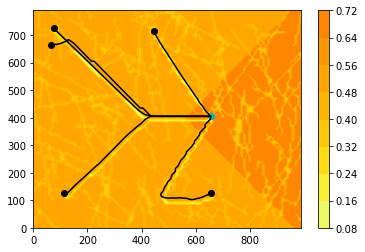

In [281]:
#Plot
paths = catchment.conduits_hfm
#f,ax = plt.subplots(1,1)
plt.contourf(catchment.grid.x,catchment.grid.y, catchment.maps['cost'][1], cmap='Wistia')
#plt.contourf(catchment.grid.x,catchment.grid.y, catchment.maps['karst_hfm'][-1], cmap='Wistia')
plt.colorbar()
for iteration in catchment.conduits_hfm:
    for path in iteration:                                  #loop over paths (one per tip/starting point)
        pathX = path[0,:]                               #get list of X coord
        pathY = path[1,:]
        plt.plot(pathX,pathY, c='k')
plt.scatter(seeds[:,0], seeds[:,1], c='c')
plt.scatter(tips[ :,0],  tips[:,1], c='k')

**Run Fast Marching outside of package**

In [205]:
#Assign variables using pykasso:
xmin = catchment.grid.x0;   xmax = catchment.grid.dx*catchment.grid.xnum;  xres = catchment.grid.xnum; dx = catchment.grid.dx
ymin = catchment.grid.y0;   ymax = catchment.grid.dy*catchment.grid.ynum;  yres = catchment.grid.ynum; dy = catchment.grid.dy

seeds = catchment.outlets
tips  =  np.asarray(catchment.inlets)[:,:2]

#costmap = np.rot90(catchment.maps['cost'][0], k=3)
#dema    = np.rot90(catchment.geology.data['topography']['data'], k=3)
costmap = catchment.maps['cost'][0]
dema    = catchment.geology.data['topography']['data']

xmin: 0 	xmax: 1000 	xres: 100 	dx: 10 
ymin: 0 	ymax: 800 	yres: 80 	dy: 10
seeds [[655.0 405.0]]
tips
 [[445. 715.]
 [ 75. 725.]
 [115. 125.]
 [655. 125.]
 [ 65. 665.]]
costmap 	shape: (80, 100) 
 [[0.4 0.4 0.4 ... 0.6 0.6 0.6]
 [0.4 0.4 0.4 ... 0.6 0.6 0.6]
 [0.4 0.4 0.4 ... 0.6 0.6 0.6]
 ...
 [0.4 0.4 0.4 ... 0.6 0.6 0.6]
 [0.4 0.4 0.4 ... 0.6 0.6 0.6]
 [0.4 0.4 0.4 ... 0.6 0.6 0.6]]
dema 	shape: (80, 100) 
 [[597.5 595.  592.5 ... 355.  352.5 350. ]
 [595.  592.5 590.  ... 352.5 350.  347.5]
 [592.5 590.  587.5 ... 350.  347.5 345. ]
 ...
 [595.  592.5 590.  ... 352.5 350.  347.5]
 [597.5 595.  592.5 ... 355.  352.5 350. ]
 [600.  597.5 595.  ... 357.5 355.  352.5]]


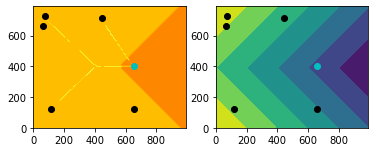

In [206]:
#Print variables being used:
print('xmin:',   xmin, '\txmax:', xmax, '\txres:', xres, '\tdx:', dx,
      '\nymin:', ymin, '\tymax:', ymax, '\tyres:', yres, '\tdy:', dy)
print('seeds',   seeds)
print('tips\n',  tips)
print('costmap \tshape:', costmap.shape, '\n', costmap)
print('dema \tshape:',    dema.shape,    '\n', dema)

f,ax = plt.subplots(1,2)
ax[0].contourf(catchment.grid.x, catchment.grid.y, catchment.maps['cost'][0], cmap='Wistia')
ax[0].scatter(seeds[:,0], seeds[:,1], c='c')
ax[0].scatter(tips[ :,0],  tips[:,1], c='k')
ax[0].set_aspect('equal')
ax[1].contourf(catchment.grid.x, catchment.grid.y, catchment.geology.data['topography']['data'])
ax[1].scatter(seeds[:,0], seeds[:,1], c='c')
ax[1].scatter(tips[ :,0],  tips[:,1], c='k')
ax[1].set_aspect('equal')

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.011 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


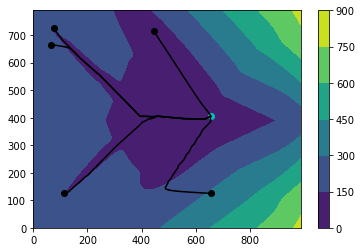

In [207]:
# Define the domain and get a coordinate system
hfmIn = Eikonal.dictIn({
    'model':             'Riemann2', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})

hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax]],dims=[xres,yres])
#hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])
#X,Y = hfmIn.Grid()  #get model grid

#Set the variables
hfmIn['seeds']  = seeds   #set the spring coordinates (need to change iteration structure to do one spring at a time)
hfmIn['tips']   = tips    #set the inlet coordinates for current iteration (rework iteration to be cleaner?)
DxV,DyV = np.gradient(dema, dx,dy, axis=(0,1,))   #x and y components of gradient in each cell of array 
#DxV,DyV = np.gradient(dema, dx,dy, axis=(0,1,))   #x and y components of gradient in each cell of array 
#DxV = np.rot90(DxV, k=3)
#DyV = np.rot90(DyV, k=3)
DxV = catchment.geology.data['orientationx']['data']
DyV = catchment.geology.data['orientationy']['data']


Cratio = 0.25                       #ratio of travel cost parallel to gradient / perpendicular to gradient
alpha = costmap             #travel cost in same direction as gradient
beta  = alpha / Cratio   #travel cost perpendicular to gradient (should be higher than parallel cost) 
alpha = np.rot90(alpha, k=3)
beta  = np.rot90(beta, k=3)
F = Riemann.needle([DxV,DyV], alpha,beta)  #convert gradient fields to hfm format & incorporate travel costs

hfmIn['metric'] = F  #set the travel cost through each cell

#Run
hfmOut = hfmIn.Run()

#Plot
paths = hfmOut['geodesics']
#f,ax = plt.subplots(1,1)
#plt.contourf(catchment.grid.x,catchment.grid.y, costmap, cmap='Wistia')
plt.contourf(catchment.grid.x,catchment.grid.y, np.rot90(hfmOut['values'],k=-3))
#plt.contourf(catchment.grid.x,catchment.grid.y, hfmOut['values'])

plt.colorbar()
for path in paths:                                  #loop over paths (one per tip/starting point)
    pathX = path[0,:]                               #get list of X coord
    pathY = path[1,:]
    plt.plot(pathX,pathY, c='k')
plt.scatter(seeds[:,0], seeds[:,1], c='c')
plt.scatter(tips[ :,0],  tips[:,1], c='k')


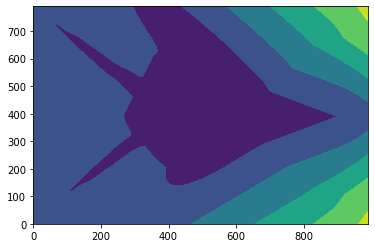

In [208]:
values = hfmOut['values']
plt.contourf(catchment.grid.x, catchment.grid.y, np.rot90(values, k=-3))

#### Original and recommended settings ####
*Velocity:* higher for easier-to-traverse fm like aquifer <br>
*Cost:* lower for easier-to-traverse fm like aquifer <br>

**Values used in HFM (for cost):**<br>
```
Ckarst          = 0.2    #travel cost in karstifiable unit (should be low)
Cnonkarst       = 0.6    #travel cost in nonkarst unit (should be high)
Cfracture       = 0.05   #travel cost in fractures
Cconduit        = 0.1    #travel cost in conduits (should be low)
Cobstacle       = 0.8    #travel cost through obstacles (should be high)
Cout            = 0.999  #travel cost in areas outside model bound (should be very high)
```
**Original values (for velocity):**
```
code aquifere   = 2 
code aquiclude  = 1 
code faults     = 4 
code fractures  = 3
code conduits   = 5 
code out        = 0.1 
```

In [34]:
print(catchment.inlets)
[item[:2] for item in catchment.inlets if item[2] == 0]

[(75.0, 725.0, 0), (495.0, 35.0, 1), (395.0, 35.0, 1), (445.0, 165.0, 2), (855.0, 15.0, 2)]


[(75.0, 725.0)]

In [4]:
#View settings:
print('geology id',       catchment.get_geology_id())
print('geology velocity', catchment.get_geology_velocity())
print('geology cost',     catchment.get_geology_cost())
print('\ncode aquifere\t',    catchment.get_code_aquifere(),
      '\ncode aquiclude\t',   catchment.get_code_aquiclude(),
      '\ncode faults\t',      catchment.get_code_faults(),
      '\ncode fractures\t',   catchment.get_code_fractures(),
      '\ncode conduits\t',    catchment.get_code_conduits(),
      '\ncode out\t',         catchment.get_code_out())
catchment.settings

geology id [2, 3]
geology velocity [2, 1]
geology cost [0.2, 0.6]

code aquifere	 2 
code aquiclude	 1 
code faults	 4 
code fractures	 3 
code conduits	 5 
code out	 0.1


{'x0': 0,
 'y0': 0,
 'xnum': 100,
 'ynum': 80,
 'dx': 10,
 'dy': 10,
 'data_has_polygon': False,
 'polygon_data': 'inputs/polygon.txt',
 'inlets_mode': 'import',
 'inlets_data': 'inputs/valley1/inlets.csv',
 'inlets_number': 1,
 'outlets_mode': 'import',
 'outlets_data': 'inputs/valley1/outlets.csv',
 'outlets_number': 1,
 'geological_mode': 'import',
 'geological_datafile': 'inputs/valley1/geology2D.gslib',
 'topography_mode': 'csv',
 'topography_datafile': 'inputs/valley1/dem.csv',
 'orientation_mode': 'topo',
 'faults_mode': 'null',
 'faults_datafile': 'inputs/faults.gslib',
 'fractures_mode': 'random',
 'fractures_datafile': 'inputs/fractures.gslib',
 'fractures_densities': [5.83e-05,
  1.38e-05,
  2.22e-05,
  2.5e-05,
  4.16e-05,
  6.66e-05,
  '5e-5'],
 'fractures_min_orientation': [0, 15, 30, 60, 105, 120, 150],
 'fractures_max_orientation': [15, 30, 45, 105, 120, 150, 180],
 'fractures_alpha': 2,
 'fractures_min_length': 50,
 'fractures_max_length': 800,
 'code_out': 0.1,
 'code

### Inputs/outputs for fast-marching ###
For compute_time_map() using skfmm: <br>
```
self.maps['time'][iteration] = skfmm.travel_time(self.maps['phi'], self.maps['velocity'][iteration], dx=self.grid.dx, order=2)
```
- phi map - where the travel time=0, i.e. the target location(s) for the base level (and springs?) (array of 0s and 1s of dim (xres,yres))
    - from compute_phi_map(), needs:
        - outlets
- velocity map - how easy it is to travel through each cell (array of dim (xres,yres), larger values=easier to travel through) 
    - from compute_velocity_map(), needs:
       - code_aquifere
       - code_aquiclude
       - code_out
- dx - cell length in each dimension (array: [dx,dy])
- order - 1 or 2 (default), order of computational stencil to use in updating points (?)

For agd-hfm: <br>
```
hfmIn = Eikonal.dictIn({
    'model':             'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])
for seed in springs:
    hfmIn['seed'] = seed
    for tip in tips:
        hfmIn['tips'] = [tip]
        hfmIn['metric']    =  F
        hfmOut = hfmIn.Run()
        paths = hfmOut['geodesics']
``` 
       
- seed - coordinates of travel time=0 location, i.e. the spring the conduits are traveling to (array of [x y z])
- tips - coordinates of starting points for walkers, i.e. the inlets (array of [[x1 y1 z1] [x2 y2 z2]]
- metric - travel cost through each cell, i.e. the inverse of the velocity (array of cost values, higher=slower to travel through). If using anisotropic FM, this will include travel cost both parallel and perpendicular to the cell's gradient.
    - to calculate travel cost metric, need:
        - DxV,DyV,DzV: x and y components of gradient in each cell of array, calculate from DEM or from geologic model orientations in each cell (arrays of dim (xres,yres)).
        - alpha: travel cost in same direction as gradient (array of dim (xres,yres) of values between 0 and 1, higher=slower)
        - beta: travel cost perpendicular to gradient (same format as alpha)
- model - which fast-marching algorithm to use (string, either Riemann2, Riemann3, Isotropic2, Isotropic3).

